SWIN Transformer Blastocyst Clasification

In this project we will train a SWIN Transformer Models to clasify blastocyst images, scored by Gardner’s criteria EXP, ICM, TE.

For each criteria a different model is trained as they are independend from eachother.

We will use the results from An annotated human blastocyst dataset to benchmark deep learning architectures for in vitro fertilization as a base line.


1. We control the randomness for more consistent training results.

In [1]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import timm
from tqdm import tqdm
from transformers import get_cosine_schedule_with_warmup

def randomness_controller(mSeed):
    # Set seed for Python's built-in random module
    random.seed(mSeed)
    # Set seed for NumPy
    np.random.seed(mSeed)
    # Set seed for PyTorch (CPU and GPU)
    torch.manual_seed(mSeed)
    # Set seed for GPU
    torch.cuda.manual_seed_all(mSeed)
    # For deterministic results(not set)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
randomness_controller(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/kavak/Masters/DeepLearning/Blastocyst-Gardner-Grading-Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. Data is loaded for each Criteria for both the train silver data set and the golden test dataset.
Silver set is split to train and validation set.
Label cleanup is performed in all datasets for labels outside the expected range.
EXP From 0-4
ICM From 0-3
TE  From 0-3

In [2]:
#Hyper Parameters
BATCH_SIZE = 16
IMAGE_SIZE = 224
TRAINING_CRITERIA ='TE'
USE_SYNTHETIC_DATA = True

# Blastocyst Gardner Grading Dataset Location
train_csv_path = Path("Blastocyst_Dataset/Gardner_train_silver.csv")
test_csv_path =  Path("Blastocyst_Dataset/Gardner_test_gold_onlyGardnerScores.csv")
image_dir = Path("Blastocyst_Dataset/Images")

# Load Silver train data and creat dataset
train_df = pd.read_csv(train_csv_path, delimiter=';',na_values=["NA"])
train_df['image_path'] = train_df['Image'].apply(lambda x: image_dir / x)
train_df = train_df.rename(columns={
    'EXP_silver': 'EXP',
    'ICM_silver': 'ICM',
    'TE_silver': 'TE'
})



# Load Golden train data and creat dataset
test_df = pd.read_csv(test_csv_path, delimiter=';',na_values=["NA"])
test_df['image_path'] = test_df['Image'].apply(lambda x: image_dir / x)
test_df = test_df.drop(columns=['Unnamed: 4'])# drop empty column 
test_df = test_df.rename(columns={
    'EXP_gold': 'EXP',
    'ICM_gold': 'ICM',
    'TE_gold': 'TE'
})


if(TRAINING_CRITERIA == 'EXP'):
    train_df = train_df.drop(columns=['ICM'])
    train_df = train_df.drop(columns=['TE'])
    test_df = test_df.drop(columns=['ICM'])
    test_df = test_df.drop(columns=['TE'])
    test_df.replace("ND", np.nan, inplace=True)
    test_df.dropna(inplace=True)
    test_df['EXP'] = test_df['EXP'].astype(int)
elif(TRAINING_CRITERIA == 'ICM'):
    train_df = train_df.drop(columns=['EXP'])
    train_df = train_df.drop(columns=['TE'])
    test_df = test_df.drop(columns=['EXP'])
    test_df = test_df.drop(columns=['TE'])
    test_df.replace("ND", 3, inplace=True)
    test_df.dropna(inplace=True)
    test_df['ICM'] = test_df['ICM'].astype(int)
else:
    train_df = train_df.drop(columns=['EXP'])
    train_df = train_df.drop(columns=['ICM'])
    test_df = test_df.drop(columns=['EXP'])
    test_df = test_df.drop(columns=['ICM'])
    test_df.replace("ND", 3, inplace=True)
    test_df.dropna(inplace=True)
    test_df['TE'] = test_df['TE'].astype(int)



train_df, val_df = train_test_split(
    train_df,
    test_size=0.05,             
    random_state=SEED,
    stratify=train_df[TRAINING_CRITERIA] 
)
print("Train set")
print(f"Train size: {len(train_df)}")
print(train_df.head())

print("\nValidation set")
print(f"Validation size: {len(val_df)}")
print(val_df.head())

print("\nTest set")
print(f"Test size: {len(test_df)}")
print(test_df.head())



Train set
Train size: 1941
           Image  TE                            image_path
523   706_01.png   0  Blastocyst_Dataset/Images/706_01.png
1787  318_03.png   0  Blastocyst_Dataset/Images/318_03.png
471   492_02.png   2  Blastocyst_Dataset/Images/492_02.png
1021  529_04.png   0  Blastocyst_Dataset/Images/529_04.png
1745  220_01.png   0  Blastocyst_Dataset/Images/220_01.png

Validation set
Validation size: 103
            Image  TE                             image_path
299    407_01.png   0   Blastocyst_Dataset/Images/407_01.png
1700   320_01.png   1   Blastocyst_Dataset/Images/320_01.png
1644   861_05.png   0   Blastocyst_Dataset/Images/861_05.png
1781   737_01.png   3   Blastocyst_Dataset/Images/737_01.png
1100  0143_02.png   0  Blastocyst_Dataset/Images/0143_02.png

Test set
Test size: 288
         Image  TE                             image_path
0  0004_03.png   1  Blastocyst_Dataset/Images/0004_03.png
1  0005_08.png   0  Blastocyst_Dataset/Images/0005_08.png
2  0008_01.png   

3. Use a custome image dataset loader to corolate the labels with the image location.
Use transform functions that perform Normalization in all 3 sets and data ogmentation in the train set.
Create the Dataset Dataloader

In [3]:
synthetic_folder = "Synthetic_GAN/"
if(USE_SYNTHETIC_DATA):
    rows = []
    synthetic_criteria_folder = os.path.join(synthetic_folder, TRAINING_CRITERIA)
    for label in range(len(os.listdir(synthetic_criteria_folder))):
        synthetic_criteria_label_folder = os.path.join(synthetic_criteria_folder, str(label))
        for image in os.listdir(synthetic_criteria_label_folder):
            new_image = {"Image": image, TRAINING_CRITERIA: label,"image_path":os.path.join(synthetic_criteria_label_folder, image)}
            rows.append(new_image)
    new_df = pd.DataFrame(rows)
    train_df = pd.concat([train_df, new_df], ignore_index=True)

print("Train set")
print(f"Train size: {len(train_df)}")
print(train_df.head())




Train set
Train size: 5941
        Image  TE                            image_path
0  706_01.png   0  Blastocyst_Dataset/Images/706_01.png
1  318_03.png   0  Blastocyst_Dataset/Images/318_03.png
2  492_02.png   2  Blastocyst_Dataset/Images/492_02.png
3  529_04.png   0  Blastocyst_Dataset/Images/529_04.png
4  220_01.png   0  Blastocyst_Dataset/Images/220_01.png


In [ ]:
# Load Custome Image Dataset connecting 
class CustomImageDataset(Dataset):
    def __init__(self, df, label_col=TRAINING_CRITERIA, transform=None):
        self.df = df.reset_index(drop=True)
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, self.label_col]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

#Workers random Seeding    
def worker_init_fn(worker_id):
    seed = SEED + worker_id  
    np.random.seed(seed)
    random.seed(seed)

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
    
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
import kornia.augmentation as K
 
aug_transform = K.AugmentationSequential(
    K.RandomHorizontalFlip(p=0.5),
    K.RandomVerticalFlip(p=0.5),
    K.RandomRotation(degrees=180, p=0.2, resample='bilinear', align_corners=False),
    K.RandomAffine(degrees=0, translate=(0.06,0.06)),
    data_keys=["input"]
).to(device)

# Create Train and validation Dataset using transform
train_dataset = CustomImageDataset(train_df, transform=train_transforms,label_col=TRAINING_CRITERIA)
val_dataset = CustomImageDataset(val_df, transform=val_transforms, label_col=TRAINING_CRITERIA)

test_dataset = CustomImageDataset(test_df, transform=val_transforms,label_col=TRAINING_CRITERIA)

# Create Dataloaders 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn = worker_init_fn,num_workers=6,prefetch_factor=2,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=worker_init_fn, num_workers=6, prefetch_factor=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,worker_init_fn = worker_init_fn,num_workers=6,prefetch_factor=2,pin_memory=True)

4. Model class for model training and testing.

Model virables:
    Model_name,
    Pretrained or not pretrained,
    Use class weights or not,
    Drop rate,
    Freez level
Train virables:
    Number of Epochs,
    Weight decay,
    Warmup,
    Patience

Loss function used CrossEntropyLoss. 
Optimiser used AdamW.

In [ ]:

class ClassificationModel:
    def __init__(self, model_name, train_df, train_loader, val_loader,test_loader, label_name = TRAINING_CRITERIA, pretrained=True, use_class_weights = False,drop_path_rate = 0.2, device='cuda',freeze_level = None):
        self.model_name = model_name
        self.train_df = train_df
        self.train_loader = train_loader
        self.val_loader = val_loader 
        self.test_loader = test_loader
        self.pretrained = pretrained
        self.device = device
        self.label_name = label_name
        self.drop_path_rate = drop_path_rate
        self.freeze_level = freeze_level
        self.model = self.create_model()
        self.use_class_weights = use_class_weights
        self.class_weights = self.get_class_weights()
    
    def create_model(self):
        num_classes = len(self.train_df[self.label_name].unique())
        model = timm.create_model(self.model_name, pretrained=self.pretrained, num_classes=num_classes,drop_path_rate = self.drop_path_rate)
        if self.freeze_level:
            print(self.freeze_level)
            for name, param in model.named_parameters():
                if self.freeze_level == 'head':
                    # Freeze everything except classifier head
                    if 'head' not in name:
                        param.requires_grad = False
                elif self.freeze_level == 'early':
                    # Freeze embedding and early transformer layers (for Swin)
                    if 'patch_embed' in name or 'layers.0' in name:
                        param.requires_grad = False
                elif self.freeze_level == 'all':
                    # Freeze everything
                    param.requires_grad = False
        model.to(self.device)
        return model

    def get_class_weights(self):
        all_labels = self.train_df[self.label_name].values
        class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
        print(class_weights)
        return torch.tensor(class_weights, dtype=torch.float)
    
    def train(self, num_epochs=10, lr=1e-5,weight_decay = 0.01, patience = 3, warmup = 0.1):
        
        # Initialize loss function (optionally with class weights)
        if self.use_class_weights:
            criterion = nn.CrossEntropyLoss(weight=self.class_weights.to(self.device))
        else:
            criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay = weight_decay)

        # Set up cosine learning rate scheduler with warmup
        num_training_steps = len(self.train_loader) * num_epochs
        num_warmup_steps = int(warmup * num_training_steps)
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps,
        )
        
        #For early stopping
        early_stop_counter = 0
        best_val_loss = float('inf')
        best_val_accuracy = 0.0
        best_model_path = None 


        # Lists to store the history
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        learning_rates = []

        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            with tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{num_epochs}",disable=False) as pbar:
               for batch_idx, (images, labels) in enumerate(pbar):
                    
                    images, labels = images.to(self.device), labels.to(self.device)
                    optimizer.zero_grad()

                    with torch.no_grad():
                        images = aug_transform(images)

                    # Forward pass
                    outputs = self.model(images)
                    loss = criterion(outputs, labels)

                    # Scale the loss and perform backpropagation
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                    running_loss += loss.item()
                    # Compute accuracy for this batch
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    # Update the progress bar
                    accuracy = 100 * correct / total
                    pbar.set_postfix(loss=running_loss / (batch_idx + 1), accuracy=accuracy)

            # Compute average train epoch loss
            train_loss = running_loss / len(self.train_loader)
            train_accuracy = 100 * correct / total
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

            # Validate Model For early stopping
            self.model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, targets in self.val_loader:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() 

                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()
            
            # Compute average validation epoch loss
            val_loss /= len(self.val_loader)
            val_accuracy = 100 * correct / total

            current_lr = optimizer.param_groups[0]['lr']
            learning_rates.append(current_lr)

            # Store the results for plotting
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch+1}/{num_epochs} - "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}% | "
            f"LR: {current_lr:.6f}")

            # Save Most Accurate Model
            if(USE_SYNTHETIC_DATA):
                folder_name = "Synthetic/"+self.label_name
            else:
                folder_name = "Real/"+self.label_name
            os.makedirs(folder_name, exist_ok=True)
            model_filename = f'best_model_acc_{val_accuracy:.4f}.pth'
            model_path = os.path.join(folder_name, model_filename)
            
            if val_accuracy >= best_val_accuracy:

                if best_model_path and os.path.exists(best_model_path):
                    os.remove(best_model_path)

                best_model_path = model_path
                best_val_accuracy = val_accuracy
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch,
                    'best_val_accuracy': best_val_accuracy
                }, best_model_path)
                
                print(f"New best model saved as {model_filename}.")

            delta = 1e-4
            num_epochs_completed = epoch + 1
            # --- Early Stopping ---
            if val_loss < best_val_loss - delta:
                best_val_loss = val_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                print(f"No improvement. Early stop counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break


        # Plot training and validation loss over epochs
        plt.figure(figsize=(18, 5))

        # Plotting loss
        plt.subplot(1, 3, 1)
        plt.plot(range(1, num_epochs_completed + 1), train_losses, label='Training Loss')
        plt.plot(range(1, num_epochs_completed + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Plotting accuracy
        plt.subplot(1, 3, 2)
        plt.plot(range(1, num_epochs_completed + 1), train_accuracies, label='Training Accuracy')
        plt.plot(range(1, num_epochs_completed + 1), val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        # Learning Rate
        plt.subplot(1, 3, 3)
        plt.plot(learning_rates[:num_epochs_completed], label='LR', color='green')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.legend()

        # Show the plot
        plt.tight_layout()
        plt.show()
        
        checkpoint = torch.load(best_model_path)
        self.model.load_state_dict(checkpoint['model_state_dict']) 
        test_acc = self.test()
        model_path = os.path.join(folder_name, f'{TRAINING_CRITERIA}_acc_{test_acc}.pth')
        os.rename(best_model_path,model_path)
        return model_path

    def test(self):
        self.model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        if self.use_class_weights:
            criterion = nn.CrossEntropyLoss(weight=self.class_weights.to(self.device))
        else:
            criterion = nn.CrossEntropyLoss()
            

        all_labels = []
        all_preds = []
        with torch.no_grad():
            for inputs, labels in self.test_loader:  
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                total += outputs.size(0)
                correct += preds.eq(labels).sum().item()
                all_labels.append(labels.cpu().numpy())
                all_preds.append(preds.cpu().numpy())

        all_labels = np.concatenate(all_labels)
        all_preds = np.concatenate(all_preds)

        avg_loss = test_loss / len(self.test_loader.dataset)
        accuracy = 100 * correct / total
        print(f"\nValidation Results — Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        
        print("Classification Report:")
        print(classification_report(all_labels, all_preds))

        print("Confusion Matrix:")
        print(confusion_matrix(all_labels, all_preds))

        return accuracy

6. List of Models to be tested.

In [6]:
model_configs = [
    ('swin_base_patch4_window7_224_pretrained', {
        'model_name': 'swin_base_patch4_window7_224',
        'pretrained': True,
        'use_class_weights': True,
        'num_epochs': 60,
        'lr':  3e-4,
        'weight_decay': 1e-4,
        'patience': 10,
        'warmup': 0.2,
        'droprate':0.7,
        'freez': None
    })
]

7. Model test loop

[0.73309477 0.99082722 1.42129187 1.08333333]


Epoch 1/60: 100%|██████████| 372/372 [03:51<00:00,  1.60it/s, accuracy=39.6, loss=1.27]

Epoch [1/60], Loss: 1.2671, Accuracy: 39.56%


Epoch 1/60 - Train Loss: 1.2671, Train Acc: 39.56% | Val Loss: 0.9287, Val Acc: 65.05% | LR: 0.000025
New best model saved as best_model_acc_65.0485.pth.


Epoch 2/60: 100%|██████████| 372/372 [03:51<00:00,  1.60it/s, accuracy=74.8, loss=0.6]  

Epoch [2/60], Loss: 0.6003, Accuracy: 74.77%


Epoch 2/60 - Train Loss: 0.6003, Train Acc: 74.77% | Val Loss: 0.8076, Val Acc: 63.11% | LR: 0.000050


Epoch 3/60: 100%|██████████| 372/372 [03:56<00:00,  1.58it/s, accuracy=83.2, loss=0.391]

Epoch [3/60], Loss: 0.3910, Accuracy: 83.17%


Epoch 3/60 - Train Loss: 0.3910, Train Acc: 83.17% | Val Loss: 0.7138, Val Acc: 72.82% | LR: 0.000075
New best model saved as best_model_acc_72.8155.pth.


Epoch 4/60: 100%|██████████| 372/372 [03:56<00:00,  1.57it/s, accuracy=85.5, loss=0.336]

Epoch [4/60], Loss: 0.3363, Accuracy: 85.49%


Epoch 4/60 - Train Loss: 0.3363, Train Acc: 85.49% | Val Loss: 0.6779, Val Acc: 68.93% | LR: 0.000100


Epoch 5/60: 100%|██████████| 372/372 [03:59<00:00,  1.55it/s, accuracy=87.5, loss=0.3]  

Epoch [5/60], Loss: 0.3005, Accuracy: 87.51%


Epoch 5/60 - Train Loss: 0.3005, Train Acc: 87.51% | Val Loss: 0.6523, Val Acc: 72.82% | LR: 0.000125
New best model saved as best_model_acc_72.8155.pth.


Epoch 6/60: 100%|██████████| 372/372 [03:58<00:00,  1.56it/s, accuracy=87.3, loss=0.3]  

Epoch [6/60], Loss: 0.2995, Accuracy: 87.33%


Epoch 6/60 - Train Loss: 0.2995, Train Acc: 87.33% | Val Loss: 0.6653, Val Acc: 74.76% | LR: 0.000150
New best model saved as best_model_acc_74.7573.pth.
No improvement. Early stop counter: 1/10


Epoch 7/60: 100%|██████████| 372/372 [03:56<00:00,  1.58it/s, accuracy=86.6, loss=0.306]

Epoch [7/60], Loss: 0.3063, Accuracy: 86.58%


Epoch 7/60 - Train Loss: 0.3063, Train Acc: 86.58% | Val Loss: 0.5987, Val Acc: 75.73% | LR: 0.000175
New best model saved as best_model_acc_75.7282.pth.


Epoch 8/60: 100%|██████████| 372/372 [03:52<00:00,  1.60it/s, accuracy=87.4, loss=0.29] 

Epoch [8/60], Loss: 0.2904, Accuracy: 87.36%


Epoch 8/60 - Train Loss: 0.2904, Train Acc: 87.36% | Val Loss: 0.5684, Val Acc: 78.64% | LR: 0.000200
New best model saved as best_model_acc_78.6408.pth.


Epoch 9/60: 100%|██████████| 372/372 [03:55<00:00,  1.58it/s, accuracy=87.7, loss=0.289]

Epoch [9/60], Loss: 0.2888, Accuracy: 87.68%


Epoch 9/60 - Train Loss: 0.2888, Train Acc: 87.68% | Val Loss: 0.9626, Val Acc: 65.05% | LR: 0.000225
No improvement. Early stop counter: 1/10


Epoch 10/60: 100%|██████████| 372/372 [03:53<00:00,  1.60it/s, accuracy=87.6, loss=0.312]

Epoch [10/60], Loss: 0.3116, Accuracy: 87.56%


Epoch 10/60 - Train Loss: 0.3116, Train Acc: 87.56% | Val Loss: 0.5758, Val Acc: 80.58% | LR: 0.000250
New best model saved as best_model_acc_80.5825.pth.
No improvement. Early stop counter: 2/10


Epoch 11/60: 100%|██████████| 372/372 [03:48<00:00,  1.62it/s, accuracy=87.5, loss=0.292]

Epoch [11/60], Loss: 0.2922, Accuracy: 87.48%


Epoch 11/60 - Train Loss: 0.2922, Train Acc: 87.48% | Val Loss: 0.6435, Val Acc: 71.84% | LR: 0.000275
No improvement. Early stop counter: 3/10


Epoch 12/60: 100%|██████████| 372/372 [03:48<00:00,  1.63it/s, accuracy=86.2, loss=0.324]

Epoch [12/60], Loss: 0.3238, Accuracy: 86.18%


Epoch 12/60 - Train Loss: 0.3238, Train Acc: 86.18% | Val Loss: 0.6490, Val Acc: 73.79% | LR: 0.000300
No improvement. Early stop counter: 4/10


Epoch 13/60: 100%|██████████| 372/372 [03:55<00:00,  1.58it/s, accuracy=87, loss=0.312]  

Epoch [13/60], Loss: 0.3123, Accuracy: 87.04%


Epoch 13/60 - Train Loss: 0.3123, Train Acc: 87.04% | Val Loss: 0.6670, Val Acc: 63.11% | LR: 0.000300
No improvement. Early stop counter: 5/10


Epoch 14/60: 100%|██████████| 372/372 [03:53<00:00,  1.60it/s, accuracy=87.9, loss=0.276]

Epoch [14/60], Loss: 0.2761, Accuracy: 87.88%


Epoch 14/60 - Train Loss: 0.2761, Train Acc: 87.88% | Val Loss: 0.5828, Val Acc: 78.64% | LR: 0.000299
No improvement. Early stop counter: 6/10


Epoch 15/60: 100%|██████████| 372/372 [03:51<00:00,  1.61it/s, accuracy=88, loss=0.293]  

Epoch [15/60], Loss: 0.2927, Accuracy: 87.96%


Epoch 15/60 - Train Loss: 0.2927, Train Acc: 87.96% | Val Loss: 0.5643, Val Acc: 74.76% | LR: 0.000297


Epoch 16/60: 100%|██████████| 372/372 [03:41<00:00,  1.68it/s, accuracy=86.9, loss=0.295]

Epoch [16/60], Loss: 0.2954, Accuracy: 86.89%


Epoch 16/60 - Train Loss: 0.2954, Train Acc: 86.89% | Val Loss: 0.6511, Val Acc: 74.76% | LR: 0.000295
No improvement. Early stop counter: 1/10


Epoch 17/60: 100%|██████████| 372/372 [03:50<00:00,  1.61it/s, accuracy=88.8, loss=0.258]

Epoch [17/60], Loss: 0.2578, Accuracy: 88.84%


Epoch 17/60 - Train Loss: 0.2578, Train Acc: 88.84% | Val Loss: 0.5859, Val Acc: 73.79% | LR: 0.000292
No improvement. Early stop counter: 2/10


Epoch 18/60: 100%|██████████| 372/372 [03:52<00:00,  1.60it/s, accuracy=89.1, loss=0.266]

Epoch [18/60], Loss: 0.2663, Accuracy: 89.06%


Epoch 18/60 - Train Loss: 0.2663, Train Acc: 89.06% | Val Loss: 0.6138, Val Acc: 77.67% | LR: 0.000289
No improvement. Early stop counter: 3/10


Epoch 19/60: 100%|██████████| 372/372 [03:50<00:00,  1.61it/s, accuracy=88.8, loss=0.254]

Epoch [19/60], Loss: 0.2538, Accuracy: 88.84%


Epoch 19/60 - Train Loss: 0.2538, Train Acc: 88.84% | Val Loss: 0.5986, Val Acc: 75.73% | LR: 0.000285
No improvement. Early stop counter: 4/10


Epoch 20/60: 100%|██████████| 372/372 [03:51<00:00,  1.61it/s, accuracy=88.9, loss=0.262]

Epoch [20/60], Loss: 0.2618, Accuracy: 88.89%


Epoch 20/60 - Train Loss: 0.2618, Train Acc: 88.89% | Val Loss: 0.5543, Val Acc: 76.70% | LR: 0.000280


Epoch 21/60: 100%|██████████| 372/372 [03:51<00:00,  1.61it/s, accuracy=89, loss=0.243]  

Epoch [21/60], Loss: 0.2435, Accuracy: 88.96%


Epoch 21/60 - Train Loss: 0.2435, Train Acc: 88.96% | Val Loss: 0.5387, Val Acc: 83.50% | LR: 0.000275
New best model saved as best_model_acc_83.4951.pth.


Epoch 22/60: 100%|██████████| 372/372 [03:51<00:00,  1.60it/s, accuracy=89.7, loss=0.235]

Epoch [22/60], Loss: 0.2354, Accuracy: 89.73%


Epoch 22/60 - Train Loss: 0.2354, Train Acc: 89.73% | Val Loss: 0.5764, Val Acc: 76.70% | LR: 0.000269
No improvement. Early stop counter: 1/10


Epoch 23/60: 100%|██████████| 372/372 [03:51<00:00,  1.61it/s, accuracy=88.8, loss=0.245]

Epoch [23/60], Loss: 0.2449, Accuracy: 88.76%


Epoch 23/60 - Train Loss: 0.2449, Train Acc: 88.76% | Val Loss: 0.6051, Val Acc: 75.73% | LR: 0.000263
No improvement. Early stop counter: 2/10


Epoch 24/60: 100%|██████████| 372/372 [03:51<00:00,  1.61it/s, accuracy=89.7, loss=0.229]

Epoch [24/60], Loss: 0.2291, Accuracy: 89.73%


Epoch 24/60 - Train Loss: 0.2291, Train Acc: 89.73% | Val Loss: 0.5766, Val Acc: 78.64% | LR: 0.000256
No improvement. Early stop counter: 3/10


Epoch 25/60: 100%|██████████| 372/372 [03:53<00:00,  1.60it/s, accuracy=90.6, loss=0.211]

Epoch [25/60], Loss: 0.2107, Accuracy: 90.62%


Epoch 25/60 - Train Loss: 0.2107, Train Acc: 90.62% | Val Loss: 0.7547, Val Acc: 69.90% | LR: 0.000249
No improvement. Early stop counter: 4/10


Epoch 26/60: 100%|██████████| 372/372 [03:53<00:00,  1.59it/s, accuracy=89.4, loss=0.229]

Epoch [26/60], Loss: 0.2294, Accuracy: 89.40%


Epoch 26/60 - Train Loss: 0.2294, Train Acc: 89.40% | Val Loss: 0.5612, Val Acc: 76.70% | LR: 0.000241
No improvement. Early stop counter: 5/10


Epoch 27/60: 100%|██████████| 372/372 [03:51<00:00,  1.61it/s, accuracy=90.5, loss=0.215]

Epoch [27/60], Loss: 0.2151, Accuracy: 90.49%


Epoch 27/60 - Train Loss: 0.2151, Train Acc: 90.49% | Val Loss: 0.7612, Val Acc: 72.82% | LR: 0.000233
No improvement. Early stop counter: 6/10


Epoch 28/60: 100%|██████████| 372/372 [03:53<00:00,  1.59it/s, accuracy=90.4, loss=0.206]

Epoch [28/60], Loss: 0.2057, Accuracy: 90.41%


Epoch 28/60 - Train Loss: 0.2057, Train Acc: 90.41% | Val Loss: 0.5842, Val Acc: 75.73% | LR: 0.000225
No improvement. Early stop counter: 7/10


Epoch 29/60: 100%|██████████| 372/372 [03:51<00:00,  1.61it/s, accuracy=90.2, loss=0.215]

Epoch [29/60], Loss: 0.2150, Accuracy: 90.20%


Epoch 29/60 - Train Loss: 0.2150, Train Acc: 90.20% | Val Loss: 0.5663, Val Acc: 75.73% | LR: 0.000216
No improvement. Early stop counter: 8/10


Epoch 30/60: 100%|██████████| 372/372 [03:51<00:00,  1.61it/s, accuracy=91.1, loss=0.197]

Epoch [30/60], Loss: 0.1966, Accuracy: 91.10%


Epoch 30/60 - Train Loss: 0.1966, Train Acc: 91.10% | Val Loss: 0.7667, Val Acc: 66.02% | LR: 0.000207
No improvement. Early stop counter: 9/10


Epoch 31/60: 100%|██████████| 372/372 [03:53<00:00,  1.59it/s, accuracy=92, loss=0.176]  

Epoch [31/60], Loss: 0.1760, Accuracy: 91.99%


Epoch 31/60 - Train Loss: 0.1760, Train Acc: 91.99% | Val Loss: 0.5523, Val Acc: 79.61% | LR: 0.000198
No improvement. Early stop counter: 10/10
Early stopping triggered.


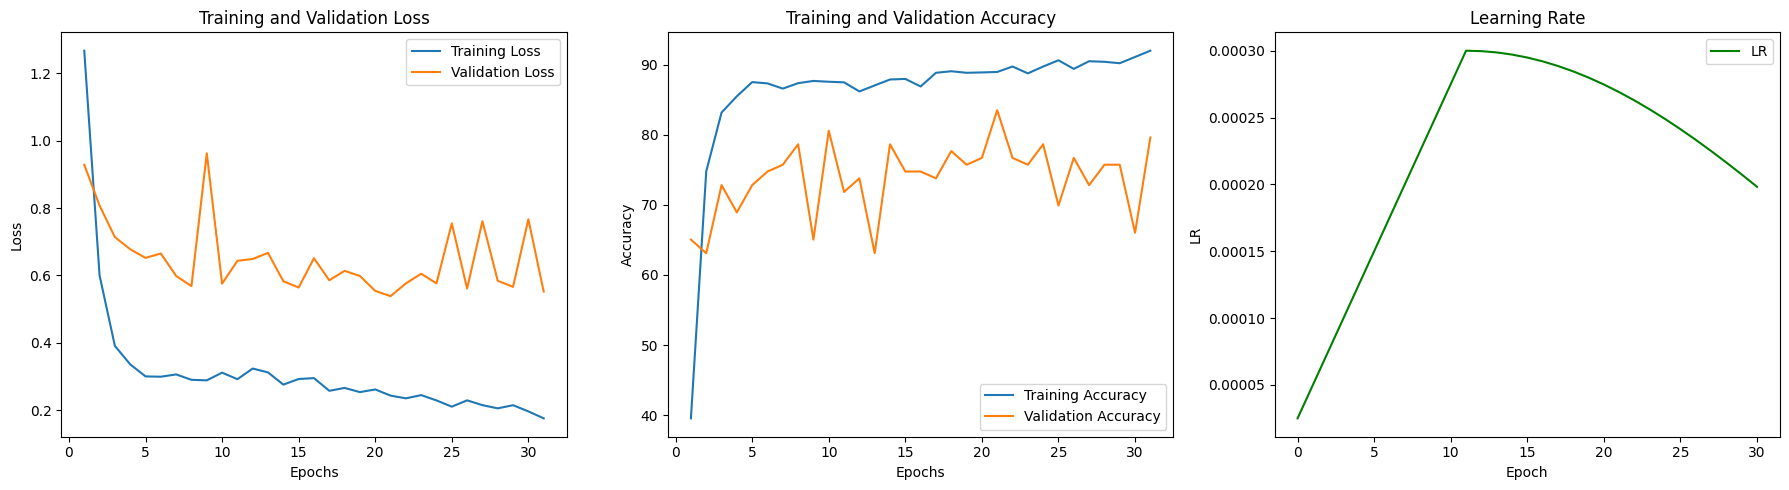


Validation Results — Loss: 0.9656, Accuracy: 65.97%
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.88      0.78       122
           1       0.47      0.40      0.43        82
           2       1.00      0.03      0.06        30
           3       0.78      0.91      0.84        54

    accuracy                           0.66       288
   macro avg       0.74      0.56      0.53       288
weighted avg       0.68      0.66      0.62       288

Confusion Matrix:
[[107  12   0   3]
 [ 38  33   0  11]
 [  4  25   1   0]
 [  5   0   0  49]]


In [ ]:
results = []
for model_name, config in model_configs:
    model = ClassificationModel(
        model_name = config['model_name'],
        pretrained = config['pretrained'],
        use_class_weights = config['use_class_weights'],
        drop_path_rate = config['droprate'],
        train_df = train_df,
        train_loader = train_loader,
        val_loader = val_loader,
        test_loader = test_loader,
        device = device,
        freeze_level = config['freez']
    )
    best_model_path = model.train(
            num_epochs=config['num_epochs'],
            lr=config['lr'],
            weight_decay=config['weight_decay'],
            patience=config['patience'],
            warmup=config['warmup']
        )
    if best_model_path is None:
        print(f"Warning: No model was saved for {model_name}")
        continue  
    cpu = torch.device("cpu")
    model.model.to(cpu)
    torch.cuda.empty_cache()


